# NLP with CNN

### Notebook objectives:

- Use CNN instead of RNN for NLP

<hr>
<hr>


## The data

In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

2022-07-01 12:11:30.372943: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 12:11:30.402941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


## Tokenize the data

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
vocab_size=len(tokenizer.word_index)

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad=pad_sequences(X_train_token, dtype=float, padding='post', maxlen=150)
X_test_pad=pad_sequences(X_test_token, dtype=float, padding='post', maxlen=150)

X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((2500, 150), (2500,), (2500, 150), (2500,))

## Using 1D Convolution.

Define a model that has :
- an `Embedding` layer: `input_dim` is the `vocab_size + 1`, `output_dim` is the embedding space dimension, and `mask_zero` has to be set to `True`. Here, for computational reasons, set `input_length` to the maximum length of your observations (that you just defined in the previous question).
- a `Conv1D` layer 
- a `Flatten` layer
- a `Dense` layer
- an output layer

Compile the model accordingly

The size of the `Conv1D` kernel corresponds exactly to the number of side-by-side words (tokens) each kernel is taking into account

In [4]:
from tensorflow.keras import models,layers

embedding_size=100

model_cnn=models.Sequential()
model_cnn.add(layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, mask_zero=True, input_length=150))
model_cnn.add(layers.Conv1D(20, kernel_size=3, activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(10, activation="relu"))
model_cnn.add(layers.Dense(1, activation="sigmoid"))

model_cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Look at the number of parameters

In [5]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          3042000   
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 20)           6020      
_________________________________________________________________
flatten (Flatten)            (None, 2960)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                29610     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,077,641
Trainable params: 3,077,641
Non-trainable params: 0
_________________________________________________________________


Fit model with a stopping criterion, and evaluate it on the test data.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

model_cnn.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=32,
          validation_split=0.3,
          verbose=0,
          callbacks=[es]
         )


res = model_cnn.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
The accuracy evaluated on the test set is of 78.240%


# Part 2 : Learn a Word2Vec representation, and then feed it into a NN with a `Conv1D`

In [7]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [8]:
word2vec=api.load('glove-wiki-gigaword-100')

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=150)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=150)

X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((2500, 150, 100), (2500,), (2500, 150, 100), (2500,))

In [112]:
from tensorflow.keras import models,layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
reg_l1 = regularizers.L1(0.001)
reg_l1l2= regularizers.L1L2(l1=0.005, l2=0.005)

model=models.Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(150,100)))
model.add(layers.Conv1D(16, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, kernel_size=2, activation='relu', kernel_regularizer=reg_l1))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu", activity_regularizer=reg_l1l2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
optim=Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history=model.fit(X_train_pad, y_train, 
          epochs=200, 
          batch_size=64,
          validation_split=0.3,
          verbose=0,
          callbacks=[es]
         )


res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
The accuracy evaluated on the test set is of 77.920%


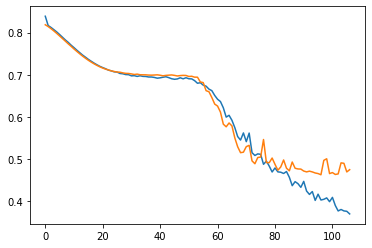

In [114]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()